# SERGIO in JAX: Fast simulation of single-cell genes expressions
## Comparison with original SERGIO in Python

In [1]:
!pip install --quiet jax jaxlib igraph matplotlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
from sergio import SergioJAX
import matplotlib.pyplot as plt
from util import scale_free_graph
# fix the random key used throughout
rng, subrng = jax.random.split(jax.random.PRNGKey(42))

First, let's specify the basic parameters of the simulation, such as number of genes, how many different cell types we want, as well as the number of cells per type.

In [4]:
# specify simulation parameters
n_genes = 100
n_cell_types = 10
n_sc = 300

# random / noise parameters
noise_amplitude = 1.0
noise_type = "dpd"
decays = 0.8

With this, we can instantiate the SERGIO class:

In [5]:
sim = SergioJAX(
    n_genes=n_genes,
    n_cell_types=n_cell_types,
    n_sc=n_sc,
    noise_amplitude=noise_amplitude,
    noise_type=noise_type,
    decays=decays,
    init_steps=0,
)

Before running SERGIO, we need to define the parameters of the simulation. These parameters are:
 * `graph`: the graph of the gene regulatory network
 * `contribution_rates`: the contribution rates of each gene to the expression of each gene
 * `basal_rates`: the basal rates of each gene

### Create a random GRN
Let us first create a random graph by sampling a scale free structure with 100 nodes. The corresponding code is found in the `util.py` file. The smaller graph is chosen to have faster simulation.

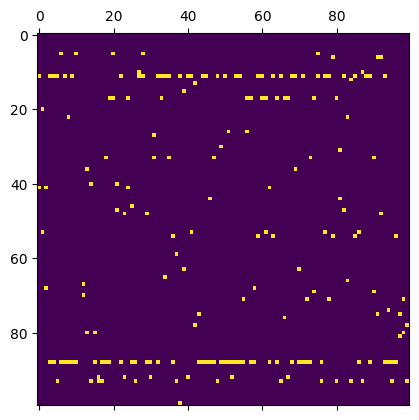

In [6]:
graph = scale_free_graph(subrng, n_genes)
plt.matshow(graph)

After, we can sample the contribution as well as basal rates. In terms of magnitude, they are uniformly spread between 1 and 5. The contribution rates have randomly flipped signs; this corresponds to choosing either an activating or repressing regulator gene.

In [7]:
rng, subrng = jax.random.split(rng)
# sample random contribution between 1 and 5
_k = jax.random.uniform(rng, minval=1.0, maxval=5.0, shape=(n_genes, n_genes))

# sample random sign (repressing or activating)
rng, subrng1, subrng2 = jax.random.split(rng, 3)
sign = (
    jax.random.bernoulli(
        subrng1,
        jax.random.beta(subrng2, a=0.5, b=0.5, shape=(n_genes, n_genes)),
        shape=(n_genes, n_genes),
    )
    * 2
    - 1
)
k = sign * _k
# go from [n_genes, n_genes] to [n_cell_types, n_genes, n_genes]
k = k[None].repeat(n_cell_types, 0)

# sample random basal rates
rng, subrng = jax.random.split(rng)
# sample random contribution between 1 and 5
basal_rates = jax.random.uniform(
    rng, minval=1.0, maxval=5.0, shape=(n_cell_types, n_genes)
)
# hill constant
hill = 2.0


Now we input these parameters to the simulator:

In [8]:
# prepare simulation
sim.custom_graph(
    graph,
    k,
    basal_rates,
    hill,
)


### Simulate clean expression data ...

In [9]:
rng, subrng = jax.random.split(rng)

# first simulate
sim.simulate(rng=subrng)

# Get the clean simulated expression matrix after steady_state simulations
# shape: [number_bins (#cell types), number_genes, number_sc (#cells per type)]
rng, subrng = jax.random.split(rng)
expr = sim.getExpressions(rng=subrng)


In [10]:
!pip install  --quiet scikit-learn umap-learn

In [11]:
# graph cant be too big for fast simulation
graph.shape

(100, 100)

## Simulation with same set of parameters and the original SERGIO

In [12]:
from original import Sergio
import numpy as np

np_rng = np.random.default_rng(42)

# sim = SergioJAX(
#     n_genes=n_genes,
#     n_cell_types=n_cell_types,
#     n_sc=n_sc,
#     noise_amplitude=noise_amplitude,
#     noise_type=noise_type,
#     decays=decays,
# )

sim_old = Sergio(
    np_rng,
    number_bins=n_cell_types,
    number_genes=n_genes,
    number_sc=n_sc,
    noise_params=noise_amplitude,
    noise_type=noise_type,
    decays=decays,
)

sim_old.custom_graph(
    g=graph,
    k=k[0],
    b=basal_rates.T,
    hill=hill * np.ones((n_genes, n_genes)),
)

In [13]:
sim_old.simulate()

In [14]:
expr_old = sim_old.getExpressions()

In [15]:
expr.shape, expr_old.shape

((10, 100, 300), (10, 100, 300))

## Comparison of simple statistics:
### Mean and variance of the expression of each gene

In [16]:
# mean across cell types and simulated cells
expr.mean((0,2))

Array([3.4423404, 6.4093943, 2.2773008, 4.2747736, 2.6772106, 3.8042793,
       3.2328184, 4.625603 , 3.756418 , 5.601436 , 1.3797995, 4.2322803,
       2.853274 , 3.1681085, 4.3643255, 4.2477293, 4.0301633, 2.1323164,
       4.331664 , 3.2484224, 4.674366 , 3.882555 , 1.9582666, 4.7224007,
       3.0083063, 3.191027 , 3.8057132, 3.056893 , 3.039887 , 3.6931555,
       2.3235908, 3.6573088, 4.655662 , 3.1214557, 3.938845 , 1.5718793,
       2.4791815, 3.1730194, 4.5586157, 5.389426 , 2.9435937, 4.180794 ,
       4.5767255, 3.1058948, 4.4826584, 5.2638474, 4.632209 , 5.4522643,
       4.0823135, 4.61418  , 3.4020674, 4.1641264, 4.9623246, 4.770859 ,
       2.431191 , 3.2313333, 4.06575  , 3.5197995, 2.6026917, 5.6731777,
       4.6828413, 5.0577703, 2.8890507, 2.770213 , 3.0918682, 2.5523837,
       4.6807747, 3.0948534, 2.6146128, 4.0158777, 3.2554102, 4.501446 ,
       4.343139 , 3.8534935, 2.0148635, 3.8079934, 3.0870087, 4.514574 ,
       5.220054 , 4.267716 , 3.6356862, 3.8883903, 

In [17]:
# mean across cell types and simulated cells
expr_old.mean((0,2))

array([3.67330297, 6.34091615, 2.51836339, 4.43939736, 3.08090079,
       3.83043841, 3.210622  , 5.45206098, 4.01221774, 6.07642087,
       1.41335057, 4.26584716, 2.81759555, 3.95206621, 3.9158645 ,
       4.21800565, 4.34211625, 2.02551443, 4.74859288, 3.55681459,
       5.01431766, 3.85229001, 1.92542226, 4.74992883, 2.95793797,
       3.63978026, 4.28739572, 2.81644951, 3.08837353, 3.94111267,
       2.47136425, 3.4812167 , 4.54433497, 3.198513  , 3.90556323,
       1.90190114, 2.37902744, 3.07034001, 4.74623769, 5.46467431,
       3.03680329, 4.37235016, 4.11351423, 3.33870906, 5.0837443 ,
       5.46967981, 4.21289657, 4.99124104, 4.12791475, 4.68748535,
       3.69415186, 4.1258195 , 5.06175421, 5.16040825, 2.53198642,
       3.51710898, 4.24636474, 3.65362674, 2.6269674 , 5.9622582 ,
       4.78383888, 5.56459391, 2.77242234, 3.0842247 , 3.47338238,
       2.7437389 , 5.18149689, 2.8986664 , 2.38136227, 4.13399474,
       3.48351047, 4.02485239, 4.37998181, 4.02984751, 2.07480

In [18]:
# differences between the means should be small
(expr.mean((0,2)) - expr_old.mean((0,2))).mean()

Array(-0.1216829, dtype=float32)

In [19]:
np.linalg.norm(expr.mean((0,2)) - expr_old.mean((0,2)))

3.1966462

In [20]:
# similarly for the standard deviations
(expr.std((0,2)) - expr_old.std((0,2))).mean()

Array(-0.01788867, dtype=float32)

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Example visualization
Let us visually compare the outputs with data standardization + PCA in order to reduce the dimensionality of the data to 2D. We then color the cells by their respective cell type and plot the result.

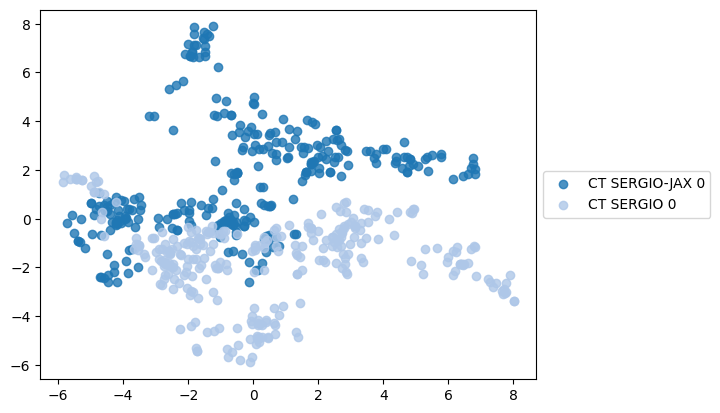

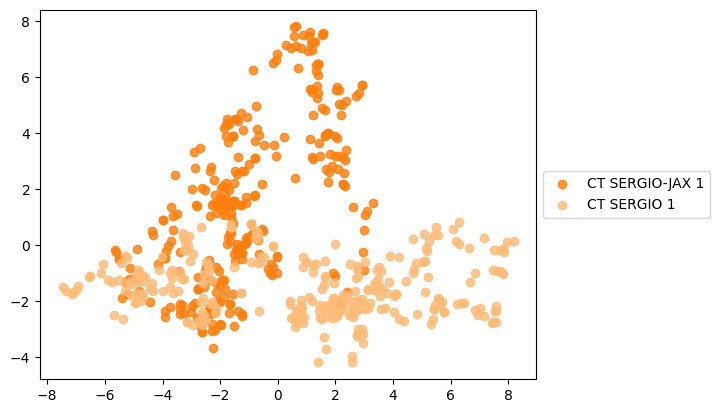

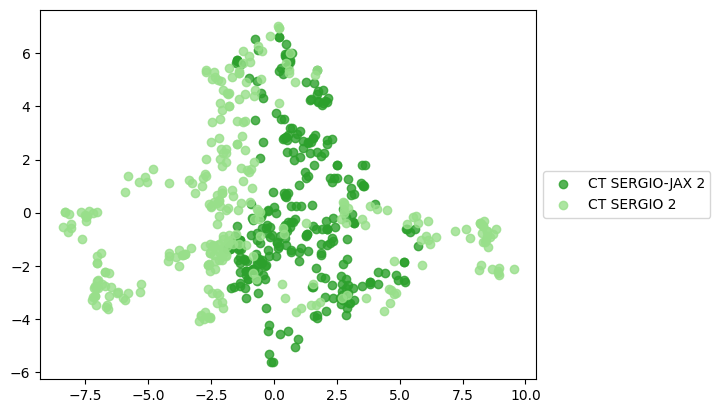

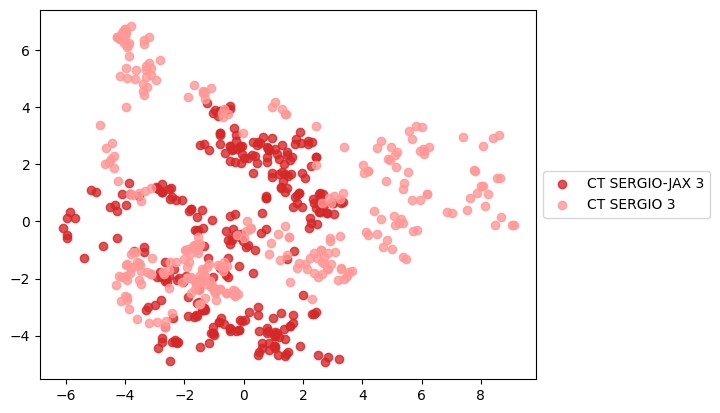

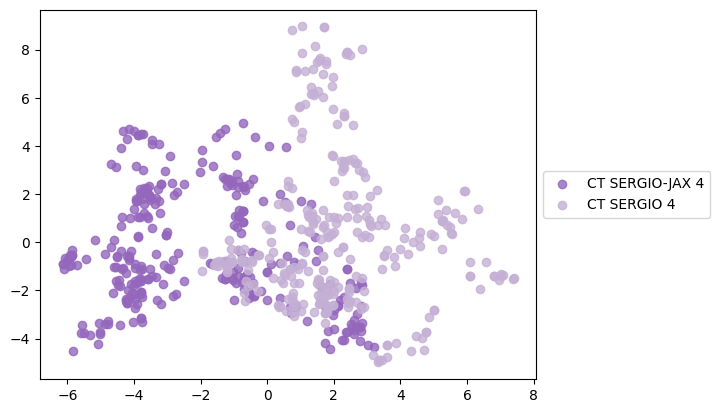

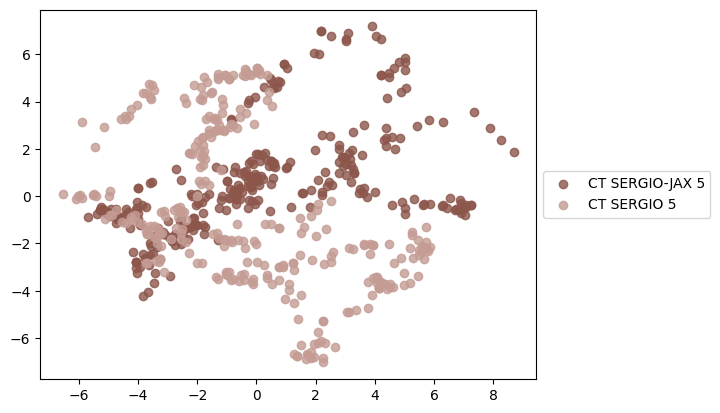

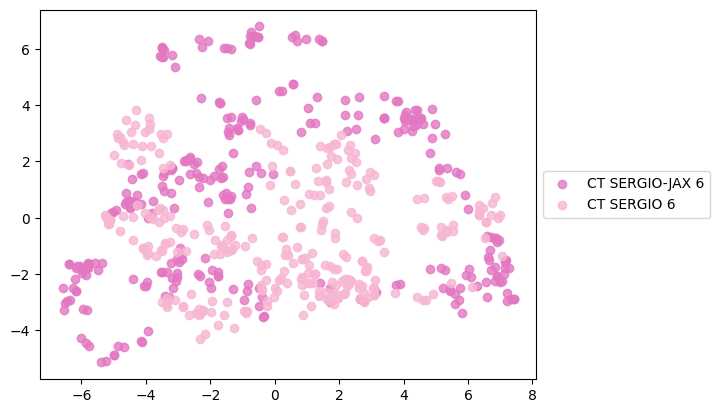

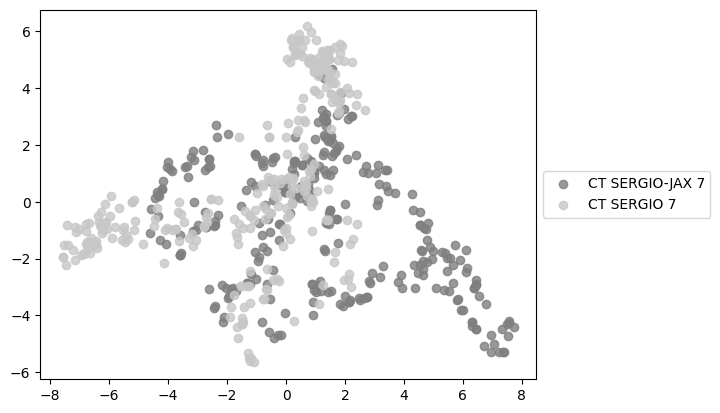

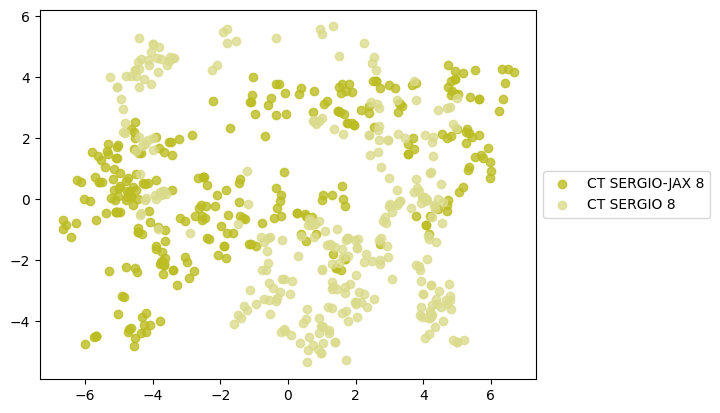

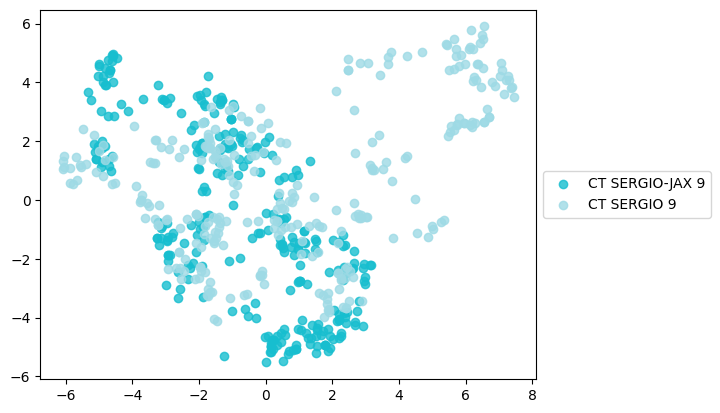

In [22]:
palette = plt.get_cmap("tab20")
for i in range(n_cell_types):
    _data = expr[i].transpose((1, 0))
    _data_old = expr_old[i].transpose((1, 0))

    flattened_combined = np.concatenate([_data, _data_old], axis=0)
    scaler = StandardScaler(with_mean=True, with_std=True).fit(flattened_combined)
    pca = PCA(n_components=50, random_state=123).fit(
        scaler.transform(flattened_combined)
    )
    # emb_pc = pca.transform(scaler.transform(flattened_combined))

    # model_umap = PCA(n_components=2, random_state=123).fit(flattened_combined)

    _data_old = scaler.transform(_data_old)
    _data_old = pca.transform(_data_old)
    # _data_old = model_umap.transform(_data_old)
    _data = scaler.transform(_data)
    _data = pca.transform(_data)
    # _data = model_umap.transform(_data)
    plt.scatter(
        _data[:, 0],
        _data[:, 1],
        alpha=0.8,
        label=f"CT SERGIO-JAX {i}",
        color=palette(2 * i),
    )
    plt.scatter(
        _data_old[:, 0],
        _data_old[:, 1],
        alpha=0.8,
        label=f"CT SERGIO {i}",
        color=palette(2 * i + 1),
        # marker="x",
    )

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

## Distributional difference
We can also compare the distribution of the expression of each gene between the two simulations.
For this, we can use methods such as the optimal transport cost or the Wasserstein distance.

In [23]:
!pip install ott-jax --quiet

In [24]:
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn


def sinkhorn_loss(
    x: jax.Array,
    y: jax.Array,
):

    # compute cost
    geom_xy = pointcloud.PointCloud(
        x,
        y,
        epsilon=0.01,
    )
    ot_prob = linear_problem.LinearProblem(
        geom_xy,
    )
    solver = sinkhorn.Sinkhorn()

    # solve ot problem
    out_xy = solver(ot_prob)

    return out_xy.reg_ot_cost

In [25]:
for i in range(n_cell_types):
    x = expr[i].transpose((1, 0))
    y = expr_old[i].transpose((1, 0))
    scaled_x = scaler.transform(x)
    scaled_y = scaler.transform(y)
    pca_x = pca.transform(scaled_x)
    pca_y = pca.transform(scaled_y)
    print(i, sinkhorn_loss(pca_x, pca_y))

0 87.746544
1 91.539154
2 98.8887
3 83.39435
4 89.739105
5 99.67689
6 88.05918
7 85.63551
8 92.43835
9 150.20416


## Pearson Correlation

In [26]:
from scipy.stats import spearmanr

for i in range(n_cell_types):
    x = expr[i].transpose((1, 0))
    y = expr_old[i].transpose((1, 0))
    # correlation between mean expression of genes for each cell type
    print(f"cell type {i}:", spearmanr(x.mean(0), y.mean(0)))

cell type 0: SignificanceResult(statistic=0.687164716471647, pvalue=2.914857516470175e-15)
cell type 1: SignificanceResult(statistic=0.6202220222022202, pvalue=5.916826722600901e-12)
cell type 2: SignificanceResult(statistic=0.7569156915691568, pvalue=8.277051674022774e-20)
cell type 3: SignificanceResult(statistic=0.7748574857485747, pvalue=3.1087182016259586e-21)
cell type 4: SignificanceResult(statistic=0.8343834383438343, pvalue=4.256752980434478e-27)
cell type 5: SignificanceResult(statistic=0.7083828382838284, pvalue=1.6720720769013226e-16)
cell type 6: SignificanceResult(statistic=0.7651605160516051, pvalue=1.8995638120894866e-20)
cell type 7: SignificanceResult(statistic=0.7570597059705971, pvalue=8.071028204112949e-20)
cell type 8: SignificanceResult(statistic=0.7993639363936393, pvalue=2.084137525726097e-23)
cell type 9: SignificanceResult(statistic=0.7247884788478847, pvalue=1.5306885737876242e-17)
